# ESDA with rgeoda and sp

by: Xun Li 10/10/2019

For people who using R to do spatial data analysis, a common routine is to use `rgdal` package to read spatial dataset, and then use `sp` package, or (in recent) `sf` package, to handle and analyze spatial data and plot the results on maps.

rgeoda provides utility functions to create a `geoda` instance from an `sp` object or `sf` object, so that users can easily integrate the functions of spatial data analysis in rgeoda into their existing work.

In this note, we will work with `sp` and `rgeoda` package to do exploratory spatial data analysis (ESDA).

## Start from sp package

The sp package has been an essential tool which provides spatial data-structures and many utility functions to do spatial analysis in R. It has been a core dependent library for many other packages, e.g. rgdal (IO), maptools (mapping), spdep (spatial weights, spatial statistics, and spatial models) etc.

Using rgdal to read a ESRI Shapefile will return a sp (Spatial object) object, which could be either a SpatialPointsDataFrame (using an AttributeList for its data slot directly), a SpatialLinesDataFrame, or a SpatialPolygonsDataFrame.

In [6]:
# use the Guerry.shp comes with the rgeoda package
guerry_path <- system.file("extdata", "Guerry.shp", package = "rgeoda")

# load rgdal library which sp is working with
library(rgdal)

Note: to install rgdal library in R, you can run: install.packages('rgdal')


Then, we can call `readOGR()` function to read Guerry.shp file and this function will returns an `sp` object

In [14]:
guerry_sp <- readOGR(guerry_path)
guerry_df <- as.data.frame(guerry_sp)

OGR data source with driver: ESRI Shapefile 
Source: "/usr/local/lib/R/3.6/site-library/rgeoda/extdata/Guerry.shp", layer: "Guerry"
with 85 features
It has 29 fields
Integer64 fields read as strings:  dept Crm_prs Crm_prp Litercy Donatns Infants Suicids MainCty Wealth Commerc Clergy Crm_prn Infntcd Dntn_cl Lottery Desertn Instrct Prsttts Area 


You can simply call plot() function to plot this map:

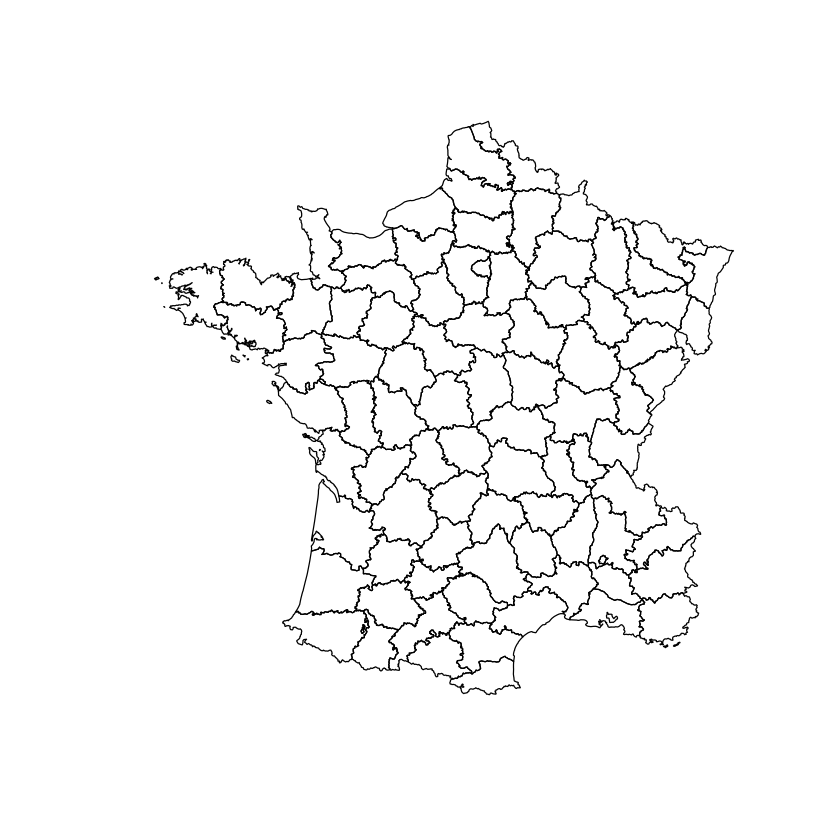

In [8]:
plot(guerry_sp)

## Create rgeoda object from sp

Everything above should be very familiar with you, right? Then, the fun part of spatial data analysis is going to start:

Create a geoda object from the sp object guerry_sp you just created.

In [12]:
library(rgeoda)

guerry <- sp_to_geoda(guerry_sp, with_table=FALSE)

That’s it! It should be very fast: rgeoda uses `wkb`, which is a binary representation of geometries, to exchange data between sp and rgeoda in memory.

Note: by default, sp_to_geoda() only using geometries to create a geoda object, which is fast and user can reuse the data.frame from the sp object to do analysis. This function has an optional parameter `with_table`, to allow user to use both geometries and data.frame to create a geoda object by calling, for example: sp_to_geoda(guerry_sp, with_table=TRUE)

## ESDA with rgeoda

Now, with the rgeoda object `guerry`, you can call rgeoda’s spatial analysis functions easily. For example, to examine the local Moran statistics of variable “crm_prs” (Population per Crime against persons):



In [52]:
queen_w <- queen_weights(guerry)


crm_prp <- as.numeric(as.character(guerry_sp$Crm_prp))
crm_prp
guerry_df <- as.data.frame(guerry_sp)
crm_prp <- guerry_df$Crm_prp
crm_prp

[1] 15890  5521  7925  7289  8174 10263  8847  9597  4086 10431  6731  5291
[13]  4500 11645 13018  5357 10503 12949  9159  7050 20235 10237  5914  7759
[25]  4774  4016  6842  7990  7204 10486  7423 10954  6524  7624  6909  8326
[37]  8059  6170  6017 12665 18043  9392  5042  9049  8943  5990  8520  7424
[49]  4950  9539  9198  6831  9190  7940  4529  8236  6175  6659  8248  4040
[61] 12141  8533  9797  7632  4920  4915  4504  7770 10708  8294  1368  2906
[73]  5786  3879  6863  7144  6241  8680  9572  5731  7566  4710  6402  9044
[85]  6516    NA

[1] 15890 5521  7925  7289  8174  10263 8847  9597  4086  10431 6731  5291 
[13] 4500  11645 13018 5357  10503 12949 9159  7050  20235 10237 5914  7759 
[25] 4774  4016  6842  7990  7204  10486 7423  10954 6524  7624  6909  8326 
[37] 8059  6170  6017  12665 18043 9392  5042  9049  8943  5990  8520  7424 
[49] 4950  9539  9198  6831  9190  7940  4529  8236  6175  6659  8248  4040 
[61] 12141 8533  9797  7632  4920  4915  4504  7770  10708 8294  1368  2906 
[73] 5786  3879  6863  7144  6241  8680  9572  5731  7566  4710  6402  9044 
[85] 6516  <NA> 
85 Levels: 10237 10263 10431 10486 10503 10708 10954 11645 12141 ... 9797


With the spatial weights and variable, we can create a local moran map:

### Local Moran Map




In [53]:
lisa <- local_moran(queen_w, crm_prp)

ERROR: Error in local_moran(queen_w, crm_prp): The size of data doesnt not match the number of observations


Now, with the LISA results, we can do exploratory spatial data analysis by generating a LISA cluster map:


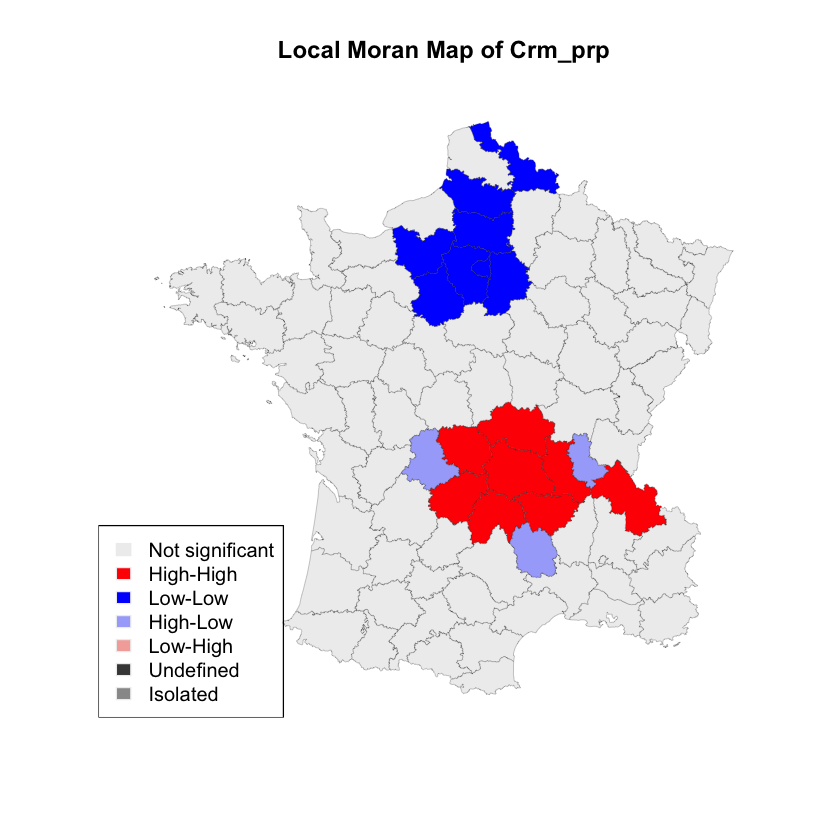

In [26]:
lisa_colors <- lisa_colors(lisa)
lisa_labels <- lisa_labels(lisa)
lisa_clusters <- lisa_clusters(lisa)

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

From the above code, you can see that we still use `sp` object to do plotting. The values of cluster indicators from rgeoda’s `LISA` object are used to make the LISA map.This emphasis that rgeoda is a API focused library, which only provides the core functions of spatial data analysis for easy integration.

You can easily append the lisa results to original sp object by manipulating the data.frame object inside the sp object.

In [31]:
guerry_sp['moran_cluster'] <- lisa_clusters

Warning message in matrix(value, n, p):
“data length [85] is not a sub-multiple or multiple of the number of columns [30]”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, iseq, value = 0L):
“invalid factor level, NA generated”
Warn

If you check the values of the cluster indicators, you will see they are integer numbers 0 (not significant), 1 (high-high cluster), 2 (low-low cluster), 3 (low-high cluster), 4 (high-low cluster), 5 (neighborless/island), 6 (undefined), which are excatly the same with GeoDa software when you save LISA results to a table:

In [32]:
lisa_clusters

[1] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 0
[39] 0 1 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 2 2 0 0 1 0 0 0 0 0 3 0 0 0 2 0 2 2 0 2
[77] 0 0 0 0 0 0 3 0 0

To create a siginificant map that is associated with the Local Moran map:


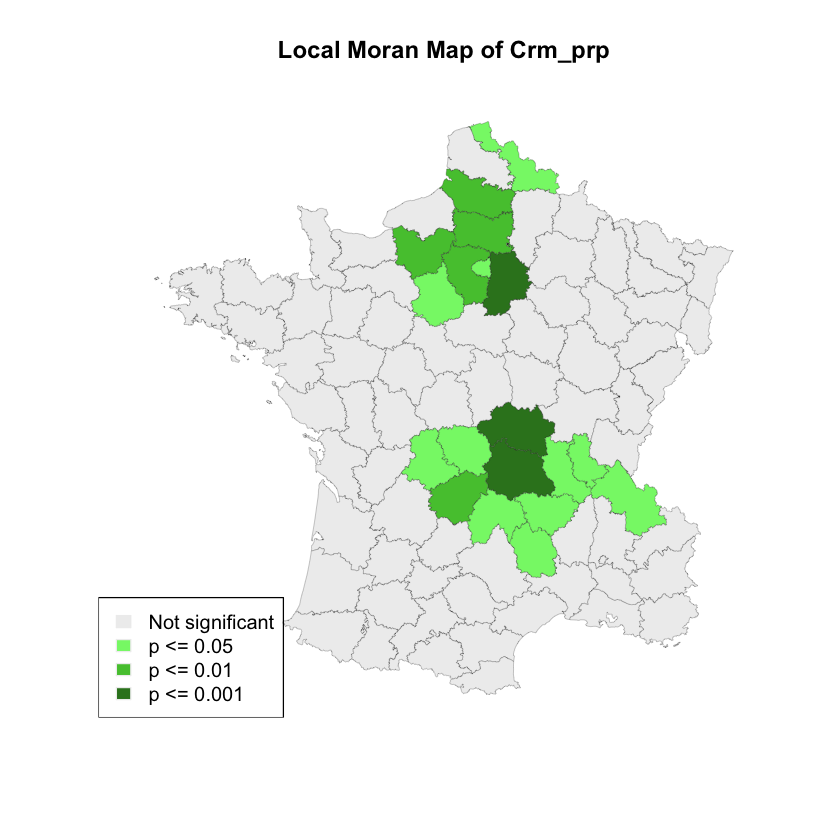

In [33]:
lisa_p <- lisa_pvalues(lisa)
p_labels <- c("Not significant", "p <= 0.05", "p <= 0.01", "p <= 0.001")
p_colors <- c("#eeeeee", "#84f576", "#53c53c", "#348124")
plot(guerry_sp, 
     col=sapply(lisa_p, function(x){
       if (x <= 0.001) return(p_colors[4])
       else if (x <= 0.01) return(p_colors[3])
       else if (x <= 0.05) return (p_colors[2])
       else return(p_colors[1])
       }), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = p_labels, fill = p_colors, border = "#eeeeee")

### Local Geary Map

Another example is to create a map of local Geary:

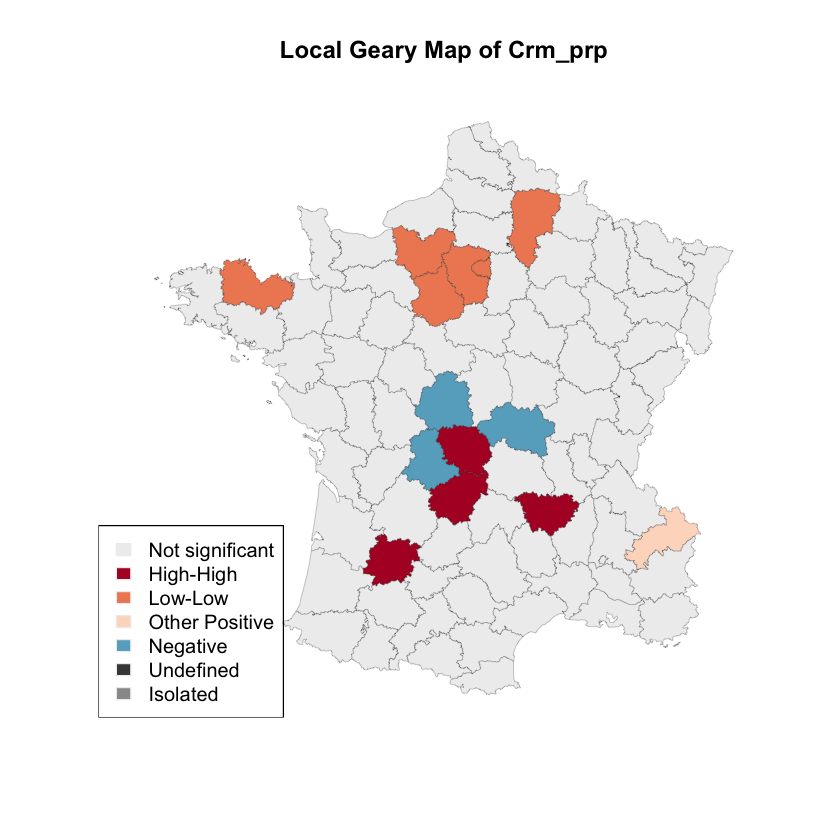

In [34]:
lisa <- local_geary(queen_w, crm_prp)
lisa_colors <- lisa_colors(lisa)
lisa_labels <- lisa_labels(lisa)
lisa_clusters <- lisa_clusters(lisa)

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Geary Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### Local G Map

To create a map of local G:

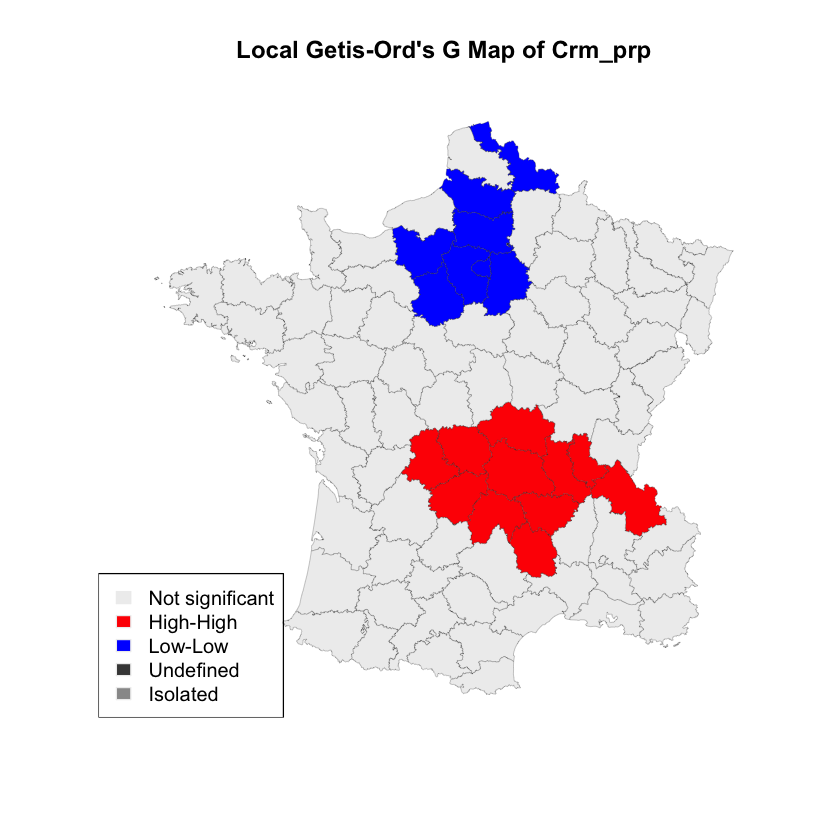

In [35]:
lisa <- local_g(queen_w, crm_prp)
lisa_colors <- lisa_colors(lisa)
lisa_labels <- lisa_labels(lisa)
lisa_clusters <- lisa_clusters(lisa)

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Getis-Ord's G Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### SKATER Map

To create a map of SKATER clustering map:

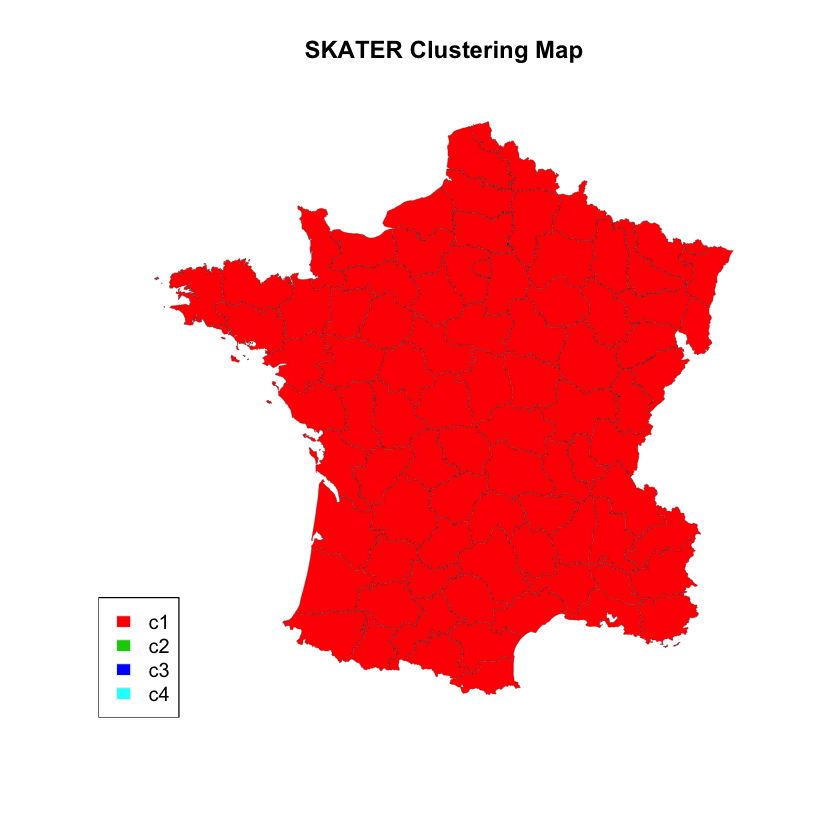

In [45]:
Crm_prp <- as.numeric(as.character(guerry_sp$Crm_prp))
Litercy <- as.numeric(as.character(guerry_sp$Litercy))
Donatns <- as.numeric(as.character(guerry_sp$Donatns))
Infants <- as.numeric(as.character(guerry_sp$Infants))
Suicids <- as.numeric(as.character(guerry_sp$Suicids))
data <- list(crm_prp, Crm_prp, Donatns, Infants, Suicids)

guerry_clusters <- skater(4, queen_w, data)

# Get some colors for each clusters
skater_colors <- palette()[2:5]
skater_labels <- c("c1","c2","c3","c4")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:4) {
  for (j in guerry_clusters[i]) {
    colors[j+1] <- skater_colors[i]
  }
}

# plot
plot(guerry_sp,  col=colors, border = "#333333", lwd=0.2)
title(main = "SKATER Clustering Map")
legend('bottomleft', legend = skater_labels, fill = skater_colors, border = "#eeeeee")

### Max-p Clustering Map

In [49]:
bound_vals <- as.numeric(guerry_sp$Pop1831)
bound_vals
min_bound <- 3236.67 # 10% of Pop1831

maxp_clusters <- maxp(queen_w, data, bound_vals, min_bound, "greedy")

# Get some colors for each clusters
maxp_colors <- palette()[2:10]
maxp_labels <- c("c1","c2","c3","c4","c5","c6","c7","c8")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:8) {
  for (j in maxp_clusters[i]) {
    colors[j+1] <- maxp_colors[i]
  }
}

# plot
plot(guerry_sp,  col=colors, border = "#333333", lwd=0.2)
title(main = "Max-p Clustering Map")
legend('bottomleft', legend = maxp_labels, fill = maxp_colors, border = "#eeeeee")

[1] 346.03 513.00 298.26 155.90 129.10 340.73 289.62 253.12 246.36 270.13
[11] 359.06 359.47 494.70 258.59 362.53 445.25 256.06 294.83 375.88 598.87
[21] 265.38 482.75 265.54 299.56 424.25 278.82 524.40 357.38 427.86 312.16
[31] 554.23 346.30 547.05 245.29 297.02 550.26 312.50 281.50 235.75 391.22
[41] 292.08 470.09 305.28 283.83 346.89 140.35 467.87 591.28 337.08 249.83
[51] 352.59 415.57 314.59 433.52 417.00 282.52 989.94 397.73 441.88 655.22
[61] 573.11 428.40 233.03 157.05 540.21 424.26 434.43 338.91 523.97 457.37
[71] 935.11 693.68 323.89 448.18 297.85 543.70 333.84 242.51 317.50 239.11
[81] 330.36 282.73 285.13 397.99 352.49   2.00

ERROR: Error in maxp(queen_w, data, bound_vals, min_bound, "greedy"): The bound_vals has to be a list of numeric values, e.g. a column of input table.
